In [30]:
import torch
from torch.utils.data import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
import torch.nn as nn

from models.custom_cnn import CustomCNN
from models.transfer_models import get_resnet18
from utils.dataset import FlowersDataset, get_test_transforms

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [32]:
# завантаження тестового датасета
num_classes = 5
test_ds = FlowersDataset("../data/processed/test", transform=get_test_transforms())
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [33]:
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            preds = torch.argmax(outputs, dim=1)

            correct += (preds == y).sum().item()
            total += y.size(0)

    return 100 * correct / total


def model_size(path):
    size_bytes = os.path.getsize(path)
    return round(size_bytes / (1024 * 1024), 2)

завантаження моделей з оцінкою

In [34]:
baseline_model = CustomCNN(num_classes=num_classes).to(device)
baseline_model.load_state_dict(torch.load("../checkpoints/baseline_best.pth", map_location=device))
baseline_val_acc = 69.72
baseline_test_acc = evaluate(baseline_model, test_loader, device)
baseline_size = model_size("../checkpoints/baseline_best.pth")
baseline_time = 8.0


In [35]:
resnet_fe = get_resnet18(num_classes=num_classes, feature_extract=True).to(device)
resnet_fe.load_state_dict(torch.load("../checkpoints/resnet_fe.pth", map_location=device))
resnet_fe_val_acc = 83.07
resnet_fe_test_acc = evaluate(resnet_fe, test_loader, device)
resnet_fe_size = model_size("../checkpoints/resnet_fe.pth")
resnet_fe_time = 4


In [36]:
resnet_ft = get_resnet18(num_classes=num_classes, feature_extract=False).to(device)
resnet_ft.load_state_dict(torch.load("../checkpoints/resnet_ft.pth", map_location=device))
resnet_ft_val_acc = 87.73
resnet_ft_test_acc = evaluate(resnet_ft, test_loader, device)
resnet_ft_size = model_size("../checkpoints/resnet_ft.pth")
resnet_ft_time = 9


In [37]:
resnet_noaug = get_resnet18(num_classes=num_classes, feature_extract=False).to(device)
resnet_noaug.load_state_dict(torch.load("../checkpoints/resnet_no_aug.pth", map_location=device))
resnet_noaug_val_acc = 87.73
resnet_noaug_test_acc = evaluate(resnet_noaug, test_loader, device)
resnet_noaug_size = model_size("../checkpoints/resnet_no_aug.pth")
resnet_noaug_time = 7.03

In [38]:
resnet_baseaug = get_resnet18(num_classes=num_classes, feature_extract=False).to(device)
resnet_baseaug.load_state_dict(torch.load("../checkpoints/resnet_baseline_aug.pth", map_location=device))
resnet_baseaug_val_acc = 89.13
resnet_baseaug_test_acc = evaluate(resnet_baseaug, test_loader, device)
resnet_baseaug_size = model_size("../checkpoints/resnet_baseline_aug.pth")
resnet_baseaug_time = 7.3

In [39]:
resnet_advaug = get_resnet18(num_classes=num_classes, feature_extract=False).to(device)
resnet_advaug.load_state_dict(torch.load("../checkpoints/resnet_advanced_aug.pth", map_location=device))
resnet_advaug_val_acc = 85.25
resnet_advaug_test_acc = evaluate(resnet_advaug, test_loader, device)
resnet_advaug_size = model_size("../checkpoints/resnet_advanced_aug.pth")
resnet_advaug_time = 8.2


In [40]:
resnet_regularized = get_resnet18(num_classes=num_classes, feature_extract=False)
resnet_regularized.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet_regularized.fc.in_features, num_classes)
)
resnet_regularized = resnet_regularized.to(device)
resnet_regularized.load_state_dict(torch.load("../checkpoints/resnet_regularized.pth", map_location=device))
resnet_regularized_val_acc = 86.18
resnet_regularized_test_acc = evaluate(resnet_regularized, test_loader, device)
resnet_regularized_size = model_size("../checkpoints/resnet_regularized.pth")
resnet_regularized_time = 7.9

In [41]:
resnet_labelsmooth = get_resnet18(num_classes=num_classes, feature_extract=False)
resnet_labelsmooth.fc = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(resnet_labelsmooth.fc.in_features, num_classes)
)
resnet_labelsmooth = resnet_labelsmooth.to(device)
resnet_labelsmooth.load_state_dict(
    torch.load("../checkpoints/resnet_label_smoothing.pth", map_location=device)
)
resnet_labelsmooth_val_acc = 84.47
resnet_labelsmooth_test_acc = evaluate(resnet_labelsmooth, test_loader, device)
resnet_labelsmooth_size = model_size("../checkpoints/resnet_label_smoothing.pth")
resnet_labelsmooth_time = 9.8


таблиця


In [42]:
df = pd.DataFrame({
    "Model": [
        "Baseline CNN",
        "ResNet18 (Feature Extraction)",
        "ResNet18 (Fine-Tuning)",
        "ResNet18 (No Augmentation)",
        "ResNet18 (Baseline Augmentation)",
        "ResNet18 (Advanced Aug + Reg)",
        "ResNet18 (Regularization)", # adv aug and dropout and l2
        "ResNet18 (Label Smoothing)",
    ],
    "Val Accuracy (%)": [
        baseline_val_acc,
        resnet_fe_val_acc,
        resnet_ft_val_acc,
        resnet_noaug_val_acc,
        resnet_baseaug_val_acc,
        resnet_advaug_val_acc,
        resnet_regularized_val_acc,
        resnet_labelsmooth_val_acc
    ],
    "Test Accuracy (%)": [
        baseline_test_acc,
        resnet_fe_test_acc,
        resnet_ft_test_acc,
        resnet_noaug_test_acc,
        resnet_baseaug_test_acc,
        resnet_advaug_test_acc,
        resnet_regularized_test_acc,
        resnet_labelsmooth_test_acc
    ],
    "Model Size (MB)": [
        baseline_size,
        resnet_fe_size,
        resnet_ft_size,
        resnet_noaug_size,
        resnet_baseaug_size,
        resnet_advaug_size,
        resnet_regularized_size,
        resnet_labelsmooth_size
    ],
    "Training Time (min)": [
        baseline_time,
        resnet_fe_time,
        resnet_ft_time,
        resnet_noaug_time,
        resnet_baseaug_time,
        resnet_advaug_time,
        resnet_regularized_time,
        resnet_labelsmooth_time
    ]
})

df.style.background_gradient(cmap='Blues')


,Model,Val Accuracy (%),Test Accuracy (%),Model Size (MB),Training Time (min)
0,Baseline CNN,69.720000,73.241590,32.370000,8.000000
1,ResNet18 (Feature Extraction),83.070000,84.250765,42.720000,4.000000
2,ResNet18 (Fine-Tuning),87.730000,88.990826,42.720000,9.000000
3,ResNet18 (No Augmentation),87.730000,87.767584,42.720000,7.030000
4,ResNet18 (Baseline Augmentation),89.130000,87.767584,42.720000,7.300000
5,ResNet18 (Advanced Aug + Reg),85.250000,86.238532,42.720000,8.200000
6,ResNet18 (Regularization),86.180000,86.391437,42.720000,7.900000
7,ResNet18 (Label Smoothing),84.470000,84.862385,42.720000,9.800000


conf matrix

In [43]:
y_true = []
y_pred = []

resnet_baseaug.eval()
with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        y_true.extend(y.numpy())

        outputs = resnet_baseaug(x)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.cpu().numpy())

<Figure size 800x800 with 0 Axes>

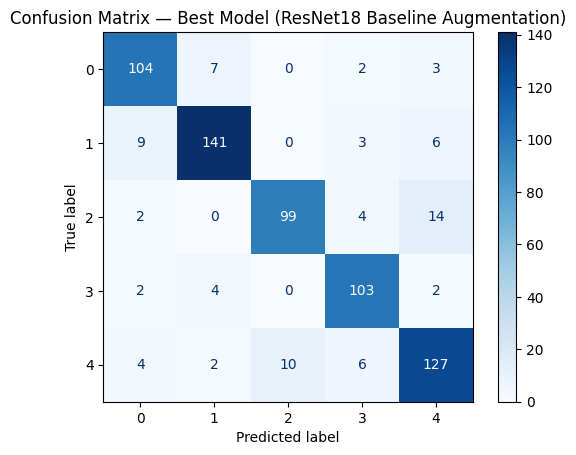

In [44]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", colorbar=True)
plt.title("Confusion Matrix — Best Model (ResNet18 Baseline Augmentation)")
plt.savefig("../results/confusion_matrix_best_baseline_aug.png", dpi=300)
plt.show()